# Loan Data Case study

In [102]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency,ttest_ind,f_oneway
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from category_encoders import TargetEncoder

In [103]:
#load the data set
df=pd.read_csv("loan.csv")
dependent_att=list()
#Viewing the content
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [104]:
#understanding the data types of the columns
print(df.shape)
df.info()

(614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [105]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [106]:
#We can see that there are null values in some of the columns
#Finding how much of the values are null
null_data=pd.DataFrame({"column_name":df.isnull().sum().index,
              "Null_Value":(df.isnull().sum())/df.shape[0]*100
             }).set_index('column_name').sort_values('Null_Value',ascending=False).reset_index()
null_data

,column_name,Null_Value
0,Credit_History,8.143322
1,Self_Employed,5.211726
2,LoanAmount,3.583062
3,Dependents,2.442997
4,Loan_Amount_Term,2.280130
5,Gender,2.117264
6,Married,0.488599
7,Loan_ID,0.000000
8,Education,0.000000
9,ApplicantIncome,0.000000


In [107]:
#We can see the columns having null value and their %. So now lets try to impute these null values
# Before doing so we need to analyse whether they have outliers or not that might impact our imputation strategy
nul_val_col=null_data[(null_data['Null_Value']!=0) & ((null_data['column_name']!='LoanAmount') &(null_data['column_name']!='Loan_Amount_Term'))]
nul_val_col

,column_name,Null_Value
0,Credit_History,8.143322
1,Self_Employed,5.211726
3,Dependents,2.442997
5,Gender,2.117264
6,Married,0.488599


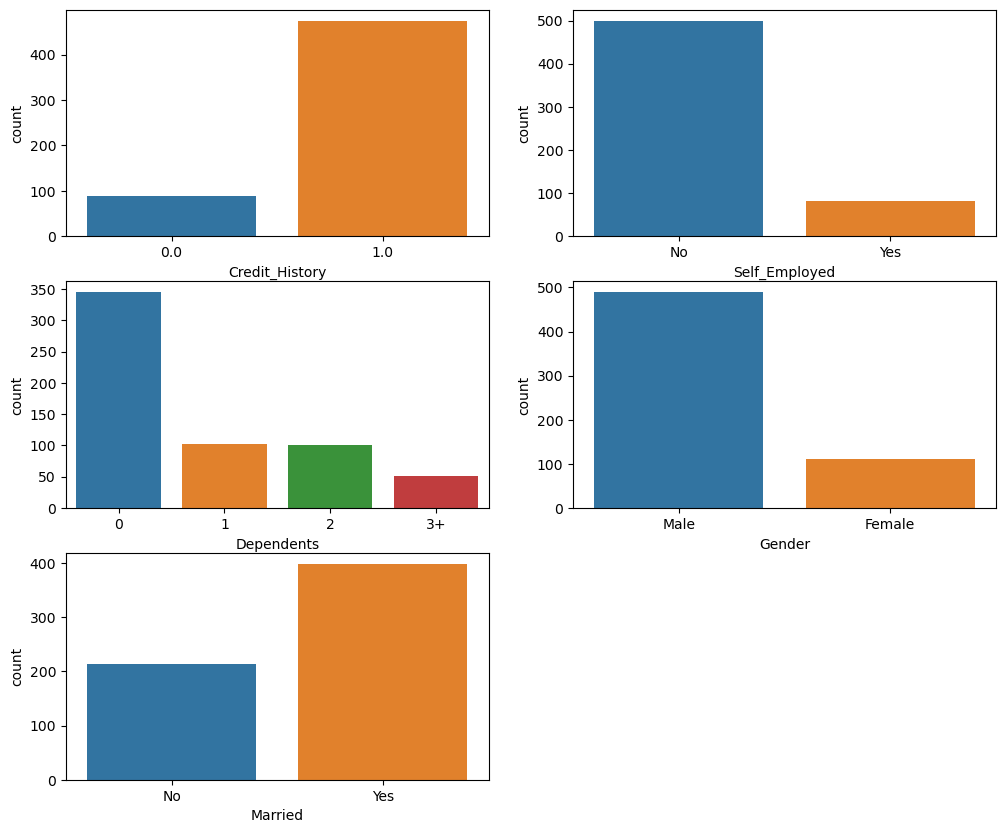

In [108]:
x=0
plt.figure(figsize=(12,10))
for col in list(nul_val_col.column_name):
    x+=1
    plt.subplot(3,2,x)
    sns.countplot(data=df,x=col)

In [109]:
#All the the above ones are categorical befor imputing these I will check if they have any impact on the 
#Loan status colum using hypothesis testing
#We will tale alpha(type 1 error) as 5% with 95% confidence level
alpha=.05
#H0:Attributes are independent 
#Ha:Attributes are dependent
col=['Credit_History','Self_Employed','Dependents','Gender','Married']
for col_name in col:
    stat,p_val,df1,expe=chi2_contingency(pd.crosstab(index=df['Loan_Status'],columns=df[col_name]).values)
    if p_val<alpha:
        print(f'Reject H0:Attributes {col_name} is dependent')
        #dependent_att.append(col_name)
    else:
        print(f'Accept H0:Attributes {col_name} is not dependent')

Reject H0:Attributes Credit_History is dependent
Accept H0:Attributes Self_Employed is not dependent
Accept H0:Attributes Dependents is not dependent
Accept H0:Attributes Gender is not dependent
Reject H0:Attributes Married is dependent


In [110]:
#So from hypothesis testing we were able to observe that credithistory and Married are dependent attributes
#Since these column are have an effect on the target colum we will not be imputing these with the mode of that colum 
#we will replace it with another value so that we know it represents null
li=list(nul_val_col.column_name)
li.remove('Credit_History')
li
df['Credit_History'].fillna(2,inplace=True)

for i in li:
    df[i].fillna(df[i].mode()[0],inplace=True)

In [111]:
(df.isna().sum())/df.shape[0]*100

Loan_ID              0.000000
Gender               0.000000
Married              0.000000
Dependents           0.000000
Education            0.000000
Self_Employed        0.000000
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       0.000000
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

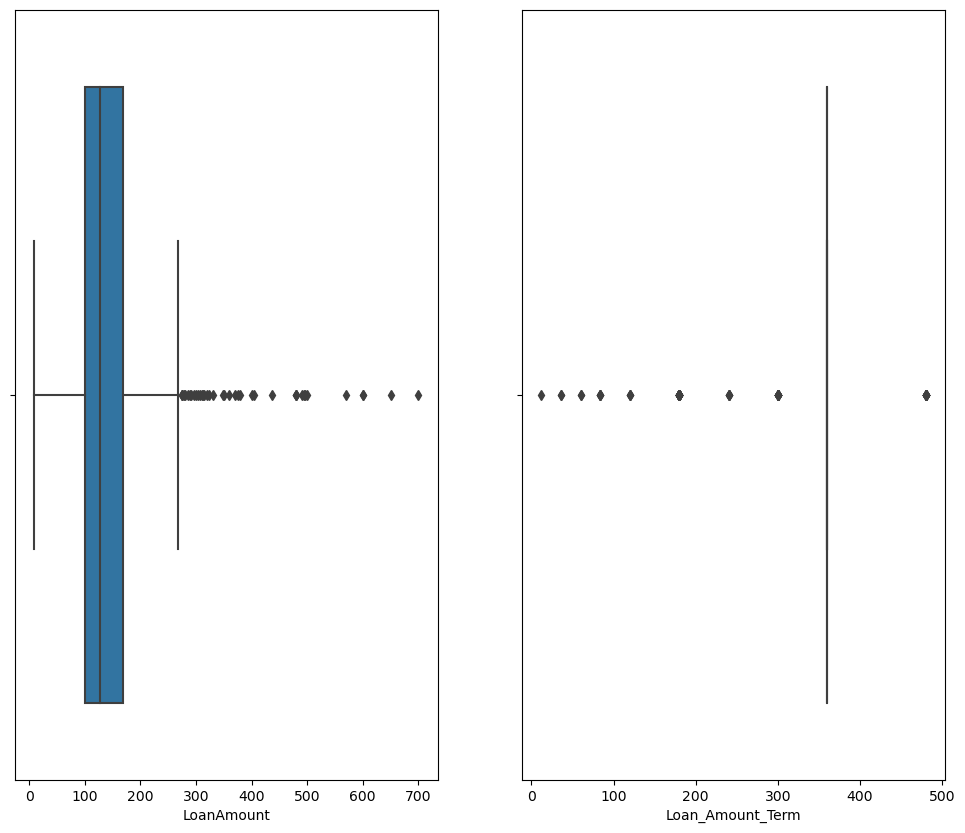

In [112]:
# we will deal with the null in LoanAmount and Loan_Amount_Term column
#Usually we replace the numerical data with the mean if there are no outliers
x=0
plt.figure(figsize=(12,10))
for col in ['LoanAmount','Loan_Amount_Term']:
    x+=1
    plt.subplot(1,2,x)
    sns.boxplot(data=df,x=col)

In [113]:
#both the attributes have outliers so will replace null values with median of the data
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(),inplace=True)

In [114]:
(df.isna().sum())/df.shape[0]*100

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

In [115]:
#We have reomve all the null values from the data set
#lets check for duplicates
df.duplicated().sum()
#There are no duplicates in the data set

0

In [116]:
df.head()
df['Credit_History']=df['Credit_History'].astype("object")
df['Loan_Amount_Term']=(df['Loan_Amount_Term']/12).astype('float')
df['Loan_Amount_Term'].value_counts()

30.0    526
15.0     44
40.0     15
25.0     13
20.0      4
7.0       4
10.0      3
5.0       2
3.0       2
1.0       1
Name: Loan_Amount_Term, dtype: int64

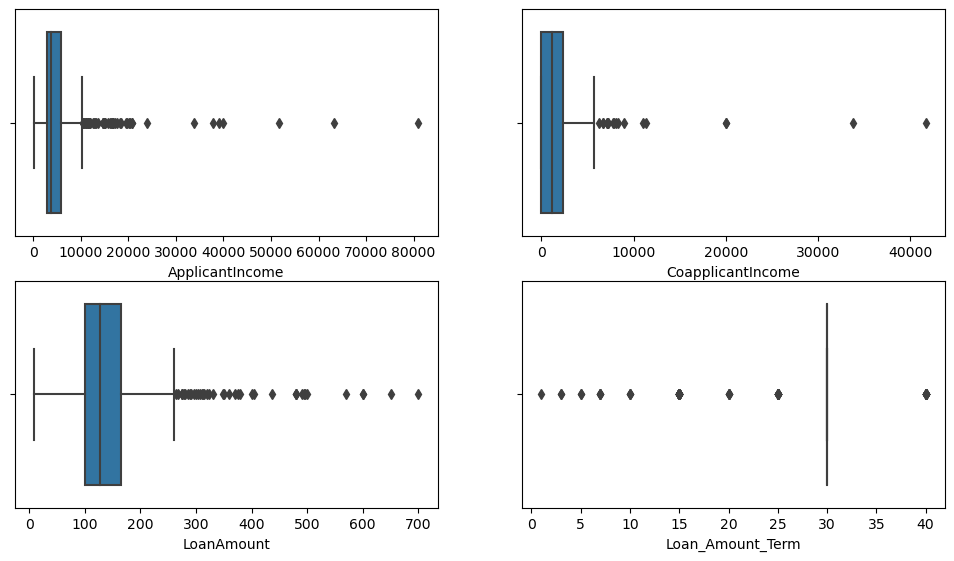

In [117]:
# Lets deal with outliers now.First we will seperate categorical and numerical data and analyse them
df_num=df.select_dtypes(include=np.number)
df_num

x=0
plt.figure(figsize=(12,10))
for i in list(df_num.columns):
    x+=1
    plt.subplot(3,2,x)
    sns.boxplot(data=df,x=i)

In [118]:
df_cat=df.select_dtypes(include='object')
df_cat

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,1.0,Urban,Y


In [119]:
#We are removing the outliers using the IQR method
q1=df_num.quantile(.25)
q2=df_num.quantile(.75)
iqr=q2-q1
iqr
lower=q1-1.5*iqr
upper=q2+1.5*iqr
clean_data=df[~((df<lower)|(df>upper)).any(axis=1)]
clean_data['EMI_per_month']=((clean_data['LoanAmount']/clean_data['Loan_Amount_Term']).astype('float')*1000/12)
clean_data['EMI_payable']=((clean_data['CoapplicantIncome'])*0.3>clean_data['EMI_per_month']).astype('int')
clean_data

C:\Users\denms\AppData\Local\Temp\ipykernel_44964\4294283588.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  clean_data=df[~((df<lower)|(df>upper)).any(axis=1)]
C:\Users\denms\AppData\Local\Temp\ipykernel_44964\4294283588.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['EMI_per_month']=((clean_data['LoanAmount']/clean_data['Loan_Amount_Term']).astype('float')*1000/12)
C:\Users\denms\AppData\Local\Temp\ipykernel_44964\4294283588.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,EMI_per_month,EMI_payable
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,30.0,1.0,Urban,Y,355.555556,0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,30.0,1.0,Rural,N,355.555556,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,30.0,1.0,Urban,Y,183.333333,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,30.0,1.0,Urban,Y,333.333333,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,30.0,1.0,Urban,Y,391.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,LP002974,Male,Yes,0,Graduate,No,3232,1950.0,108.0,30.0,1.0,Rural,Y,300.000000,1
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,30.0,1.0,Rural,Y,197.222222,0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,30.0,1.0,Urban,Y,702.777778,0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,30.0,1.0,Urban,Y,519.444444,0


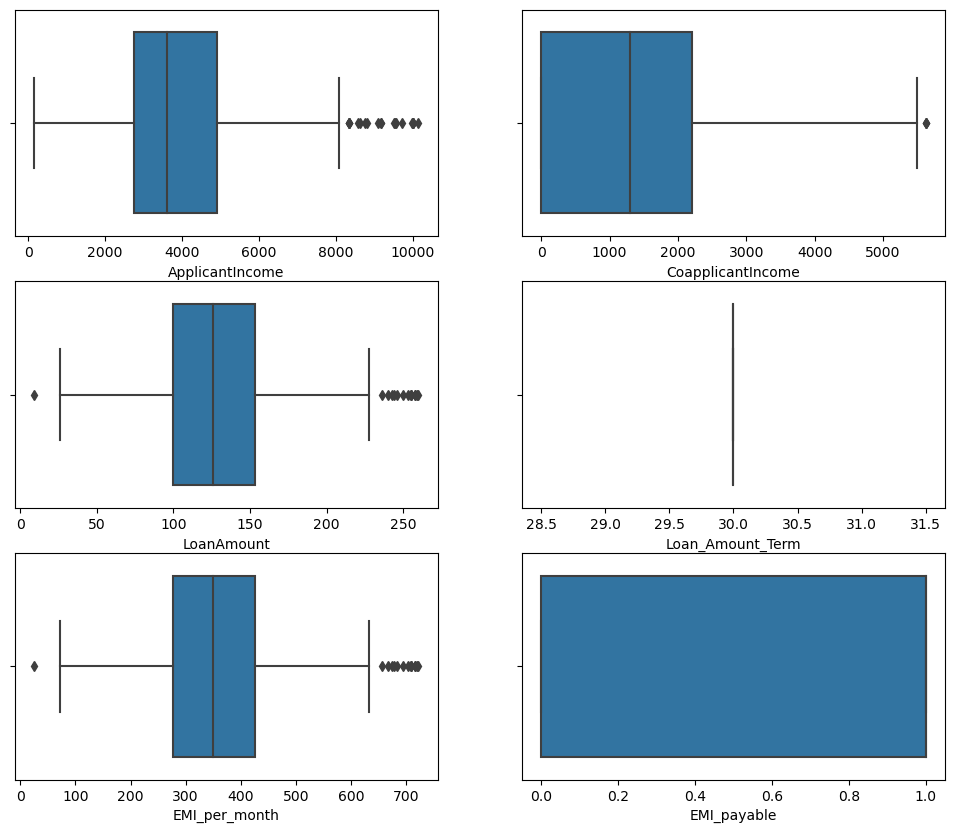

In [120]:
clean_data
df1_num=clean_data.select_dtypes(include=np.number)
x=0
plt.figure(figsize=(12,10))
for i in list(df1_num.columns):
    x+=1
    plt.subplot(3,2,x)
    sns.boxplot(data=clean_data,x=i)

In [121]:
#Compared to the previous data set we have removed most of the outliers and we have clean data now


In [122]:
#NOw lets sepereate the data based on loan status and start our analysis
cat_col=list(clean_data.select_dtypes(include='object').columns)[1:-1]
num_col=list(clean_data.select_dtypes(include=np.number).columns)
loan_y=clean_data[clean_data["Loan_Status"]=='Y']
loan_n=clean_data[clean_data["Loan_Status"]=='N']

In [123]:
#Will do hypothesis testing on categorical data to check for dependency on target column
alpha=.05
#H0:Attributes are independent 
#Ha:Attributes are dependent
for col_name in cat_col:
    stat,p_val,df1,expe=chi2_contingency(pd.crosstab(index=clean_data['Loan_Status'],columns=clean_data[col_name]).values)
    if p_val<alpha:
        print(f'Reject H0:Attributes {col_name} is dependent')
        dependent_att.append(col_name)
    else:
        print(f'Accept H0:Attributes {col_name} is not dependent')

Accept H0:Attributes Gender is not dependent
Accept H0:Attributes Married is not dependent
Accept H0:Attributes Dependents is not dependent
Accept H0:Attributes Education is not dependent
Accept H0:Attributes Self_Employed is not dependent
Reject H0:Attributes Credit_History is dependent
Reject H0:Attributes Property_Area is dependent


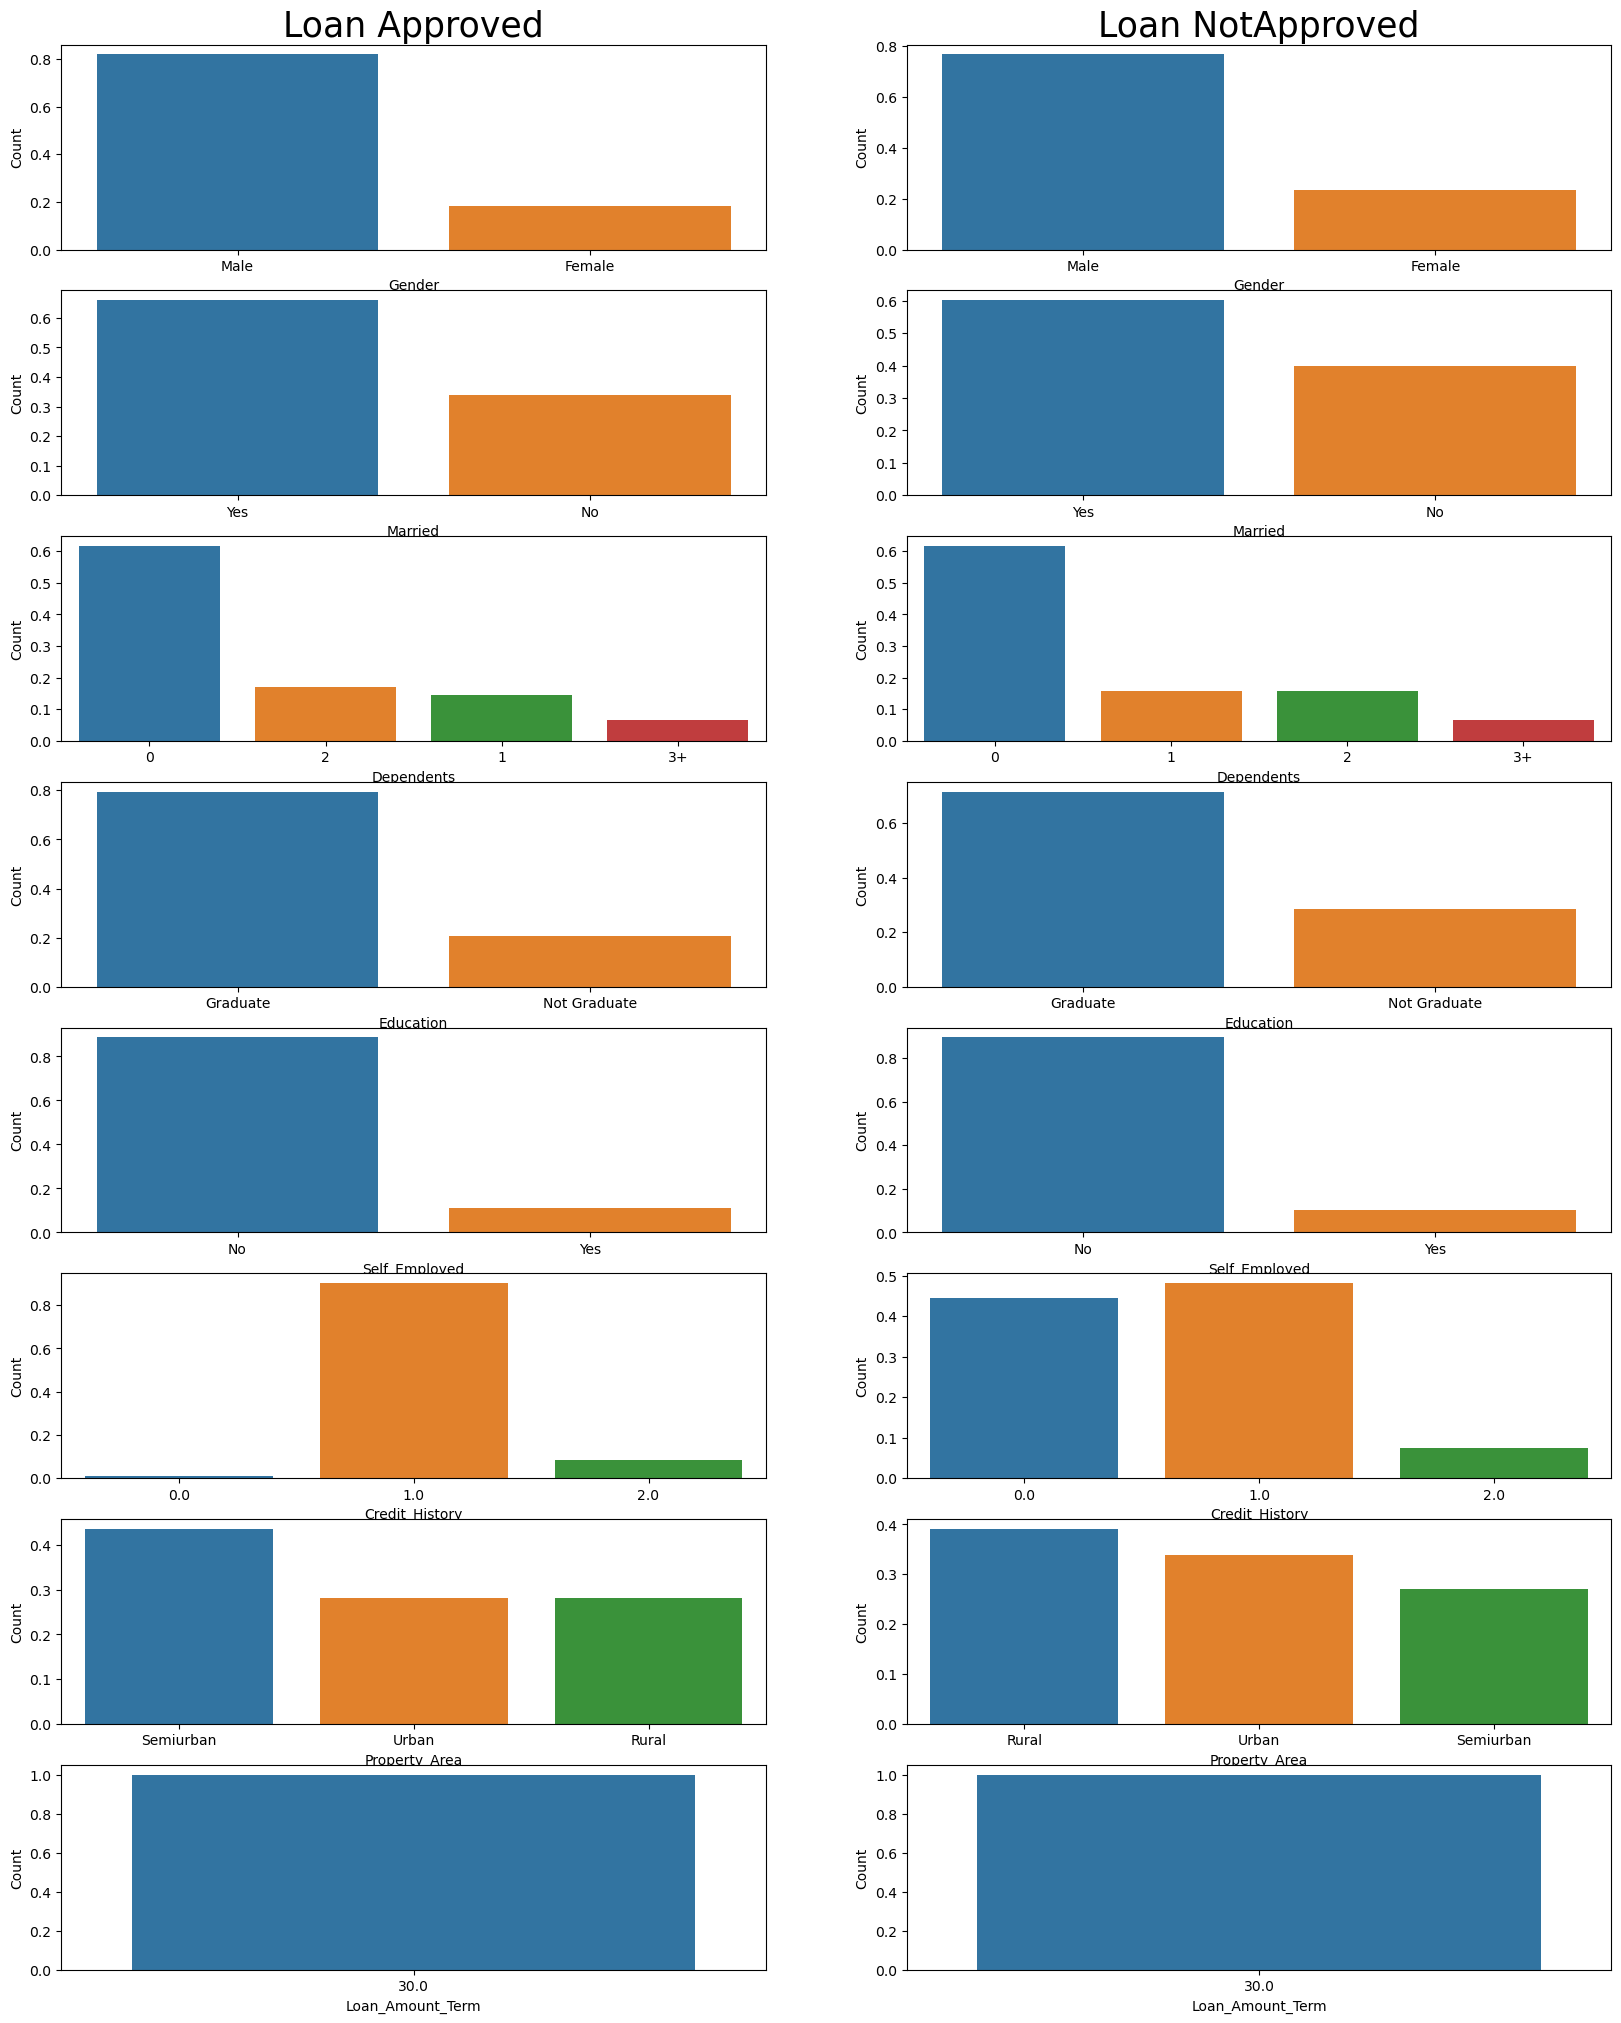

In [124]:
#Univariate analysis-categorical
x=0
plt.figure(figsize=(20,25))
cat_col.append('Loan_Amount_Term')
for col in cat_col:
    x+=1
    plt.subplot(8,2,x)
    plt.ylabel("Count")
    plt.xlabel(col)
    if x<=2:
        plt.title("Loan Approved",fontsize=25) 
    sns.barplot(x=loan_y[col].value_counts().index,y=loan_y[col].value_counts(normalize=True).values)
    
    x+=1
    plt.subplot(8,2,x)
    plt.ylabel("Count")
    plt.xlabel(col)
    if x<=2:
        plt.title("Loan NotApproved",fontsize=25) 
    sns.barplot(x=loan_n[col].value_counts().index,y=loan_n[col].value_counts(normalize=True).values)


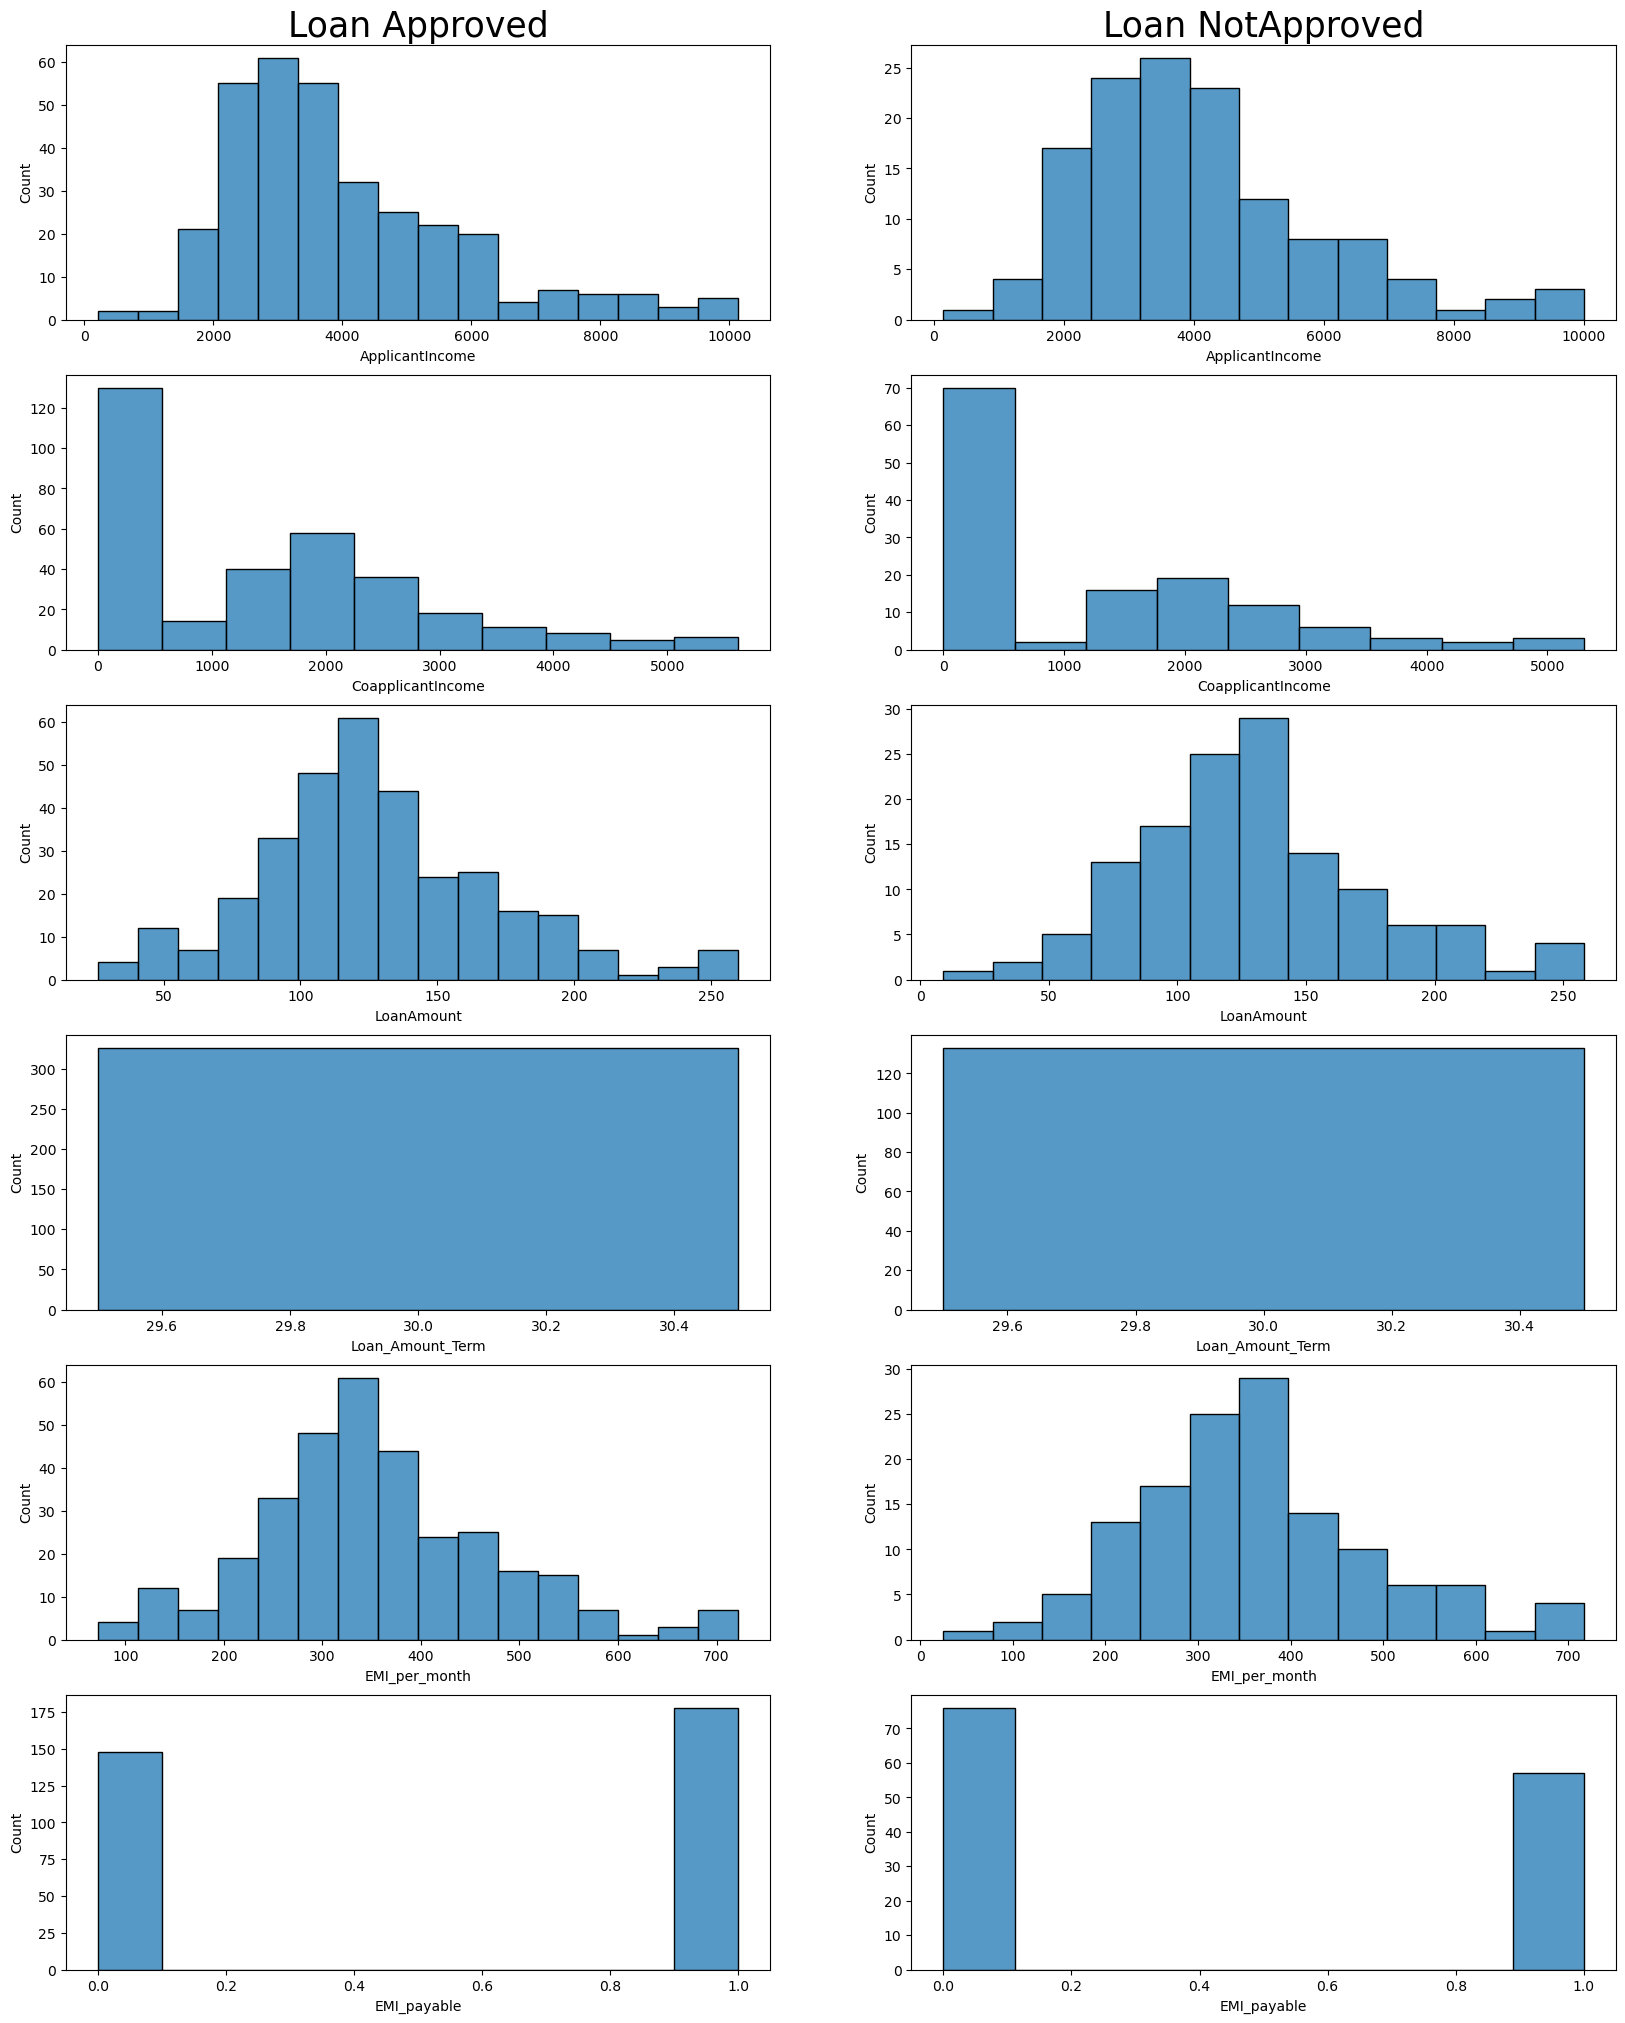

In [125]:
#Univariate analysis-numerical
x=0
plt.figure(figsize=(20,25))
for col in num_col:
    x+=1
    plt.subplot(len(num_col),2,x)
    plt.ylabel("Count")
    plt.xlabel(col)
    if x<=2:
        plt.title("Loan Approved",fontsize=25) 
    sns.histplot(loan_y[col])
    
    x+=1
    plt.subplot(len(num_col),2,x)
    plt.ylabel("Count")
    plt.xlabel(col)
    if x<=2:
        plt.title("Loan NotApproved",fontsize=25) 
    sns.histplot(loan_n[col])

In [126]:
#Will do hypothesis testing on numerical data to check for dependency on target column
alpha=.05
#H0:Attributes are independent 
#Ha:Attributes are dependent
for col_name in num_col[:-3]:
    stat,p_val=ttest_ind(loan_y[col_name],loan_n[col_name])
    if p_val<alpha:
        print(f'Reject H0:Attributes {col_name} is dependent')
        dependent_att.append(col_name)
    else:
        print(f'Accept H0:Attributes {col_name} is not dependent')

Accept H0:Attributes ApplicantIncome is not dependent
Accept H0:Attributes CoapplicantIncome is not dependent
Accept H0:Attributes LoanAmount is not dependent


In [127]:
from scipy.stats import f_oneway

for col_name in num_col[:-3]:
    stat,p_val=f_oneway(loan_y[col_name],loan_n[col_name])
    if p_val<alpha:
        print(f'Reject H0:Attributes {col_name} is dependent')
        dependent_att.append(col_name)
    else:
        print(f'Accept H0:Attributes {col_name} is not dependent')

Accept H0:Attributes ApplicantIncome is not dependent
Accept H0:Attributes CoapplicantIncome is not dependent
Accept H0:Attributes LoanAmount is not dependent


In [128]:
#normality check
from scipy.stats import shapiro
#H0:Attributes is Gaussian 
#Ha:Attributes is not Gaussian
for col_name in num_col[:-3]:
    stat,p_val=shapiro(clean_data[col_name])
    if p_val<alpha:
        print(f'Attributes is not Gaussian {col_name} ')
    else:
        print(f'Attributes is  Gaussian {col_name} ')

Attributes is not Gaussian ApplicantIncome 
Attributes is not Gaussian CoapplicantIncome 
Attributes is not Gaussian LoanAmount 


In [129]:
from scipy.stats import kruskal
#Since data is not Gaussian we do kruskal test
for col_name in num_col[:-3]:
    stat,p_val=kruskal(loan_y[col_name],loan_n[col_name])
    if p_val<alpha:
        print(f'Reject H0:Attributes {col_name} is dependent')
        dependent_att.append(col_name)
    else:
        print(f'Accept H0:Attributes {col_name} is not dependent')

Accept H0:Attributes ApplicantIncome is not dependent
Reject H0:Attributes CoapplicantIncome is dependent
Accept H0:Attributes LoanAmount is not dependent


In [130]:
### lets categorize few columns
#bins = [0,3000,7000,10200]
#group = ['Low','Average','High']
#clean_data["AppliIncome_bin"] = pd.cut(clean_data["ApplicantIncome"],bins,labels=group)
#bins = [-1,2000,4000,6000]
#group = ['Low','Average','High']
#clean_data["Co_AppliIncome_bin"] = pd.cut(clean_data["CoapplicantIncome"],bins,labels=group)

In [131]:
clean_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,EMI_per_month,EMI_payable
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,30.0,1.0,Urban,Y,355.555556,0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,30.0,1.0,Rural,N,355.555556,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,30.0,1.0,Urban,Y,183.333333,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,30.0,1.0,Urban,Y,333.333333,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,30.0,1.0,Urban,Y,391.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,LP002974,Male,Yes,0,Graduate,No,3232,1950.0,108.0,30.0,1.0,Rural,Y,300.000000,1
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,30.0,1.0,Rural,Y,197.222222,0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,30.0,1.0,Urban,Y,702.777778,0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,30.0,1.0,Urban,Y,519.444444,0


In [132]:
#will assume that 30% of applicants salary shoul cover emi


<AxesSubplot:xlabel='EMI_payable', ylabel='count'>

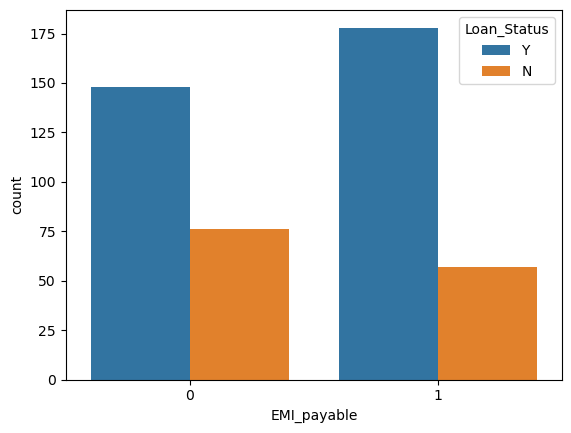

In [133]:
sns.countplot(data=clean_data,x='EMI_payable',hue='Loan_Status')

In [134]:
col_name='EMI_payable'
stat,p_val,df1,expe=chi2_contingency(pd.crosstab(index=clean_data['Loan_Status'],columns=clean_data[col_name]).values)
if p_val<alpha:
    print(f'Reject H0:Attributes EMI_payable is dependent')
    dependent_att.append(col_name)
else:
    print(f'Accept H0:Attributes EMI_payable is not dependent')

Reject H0:Attributes EMI_payable is dependent


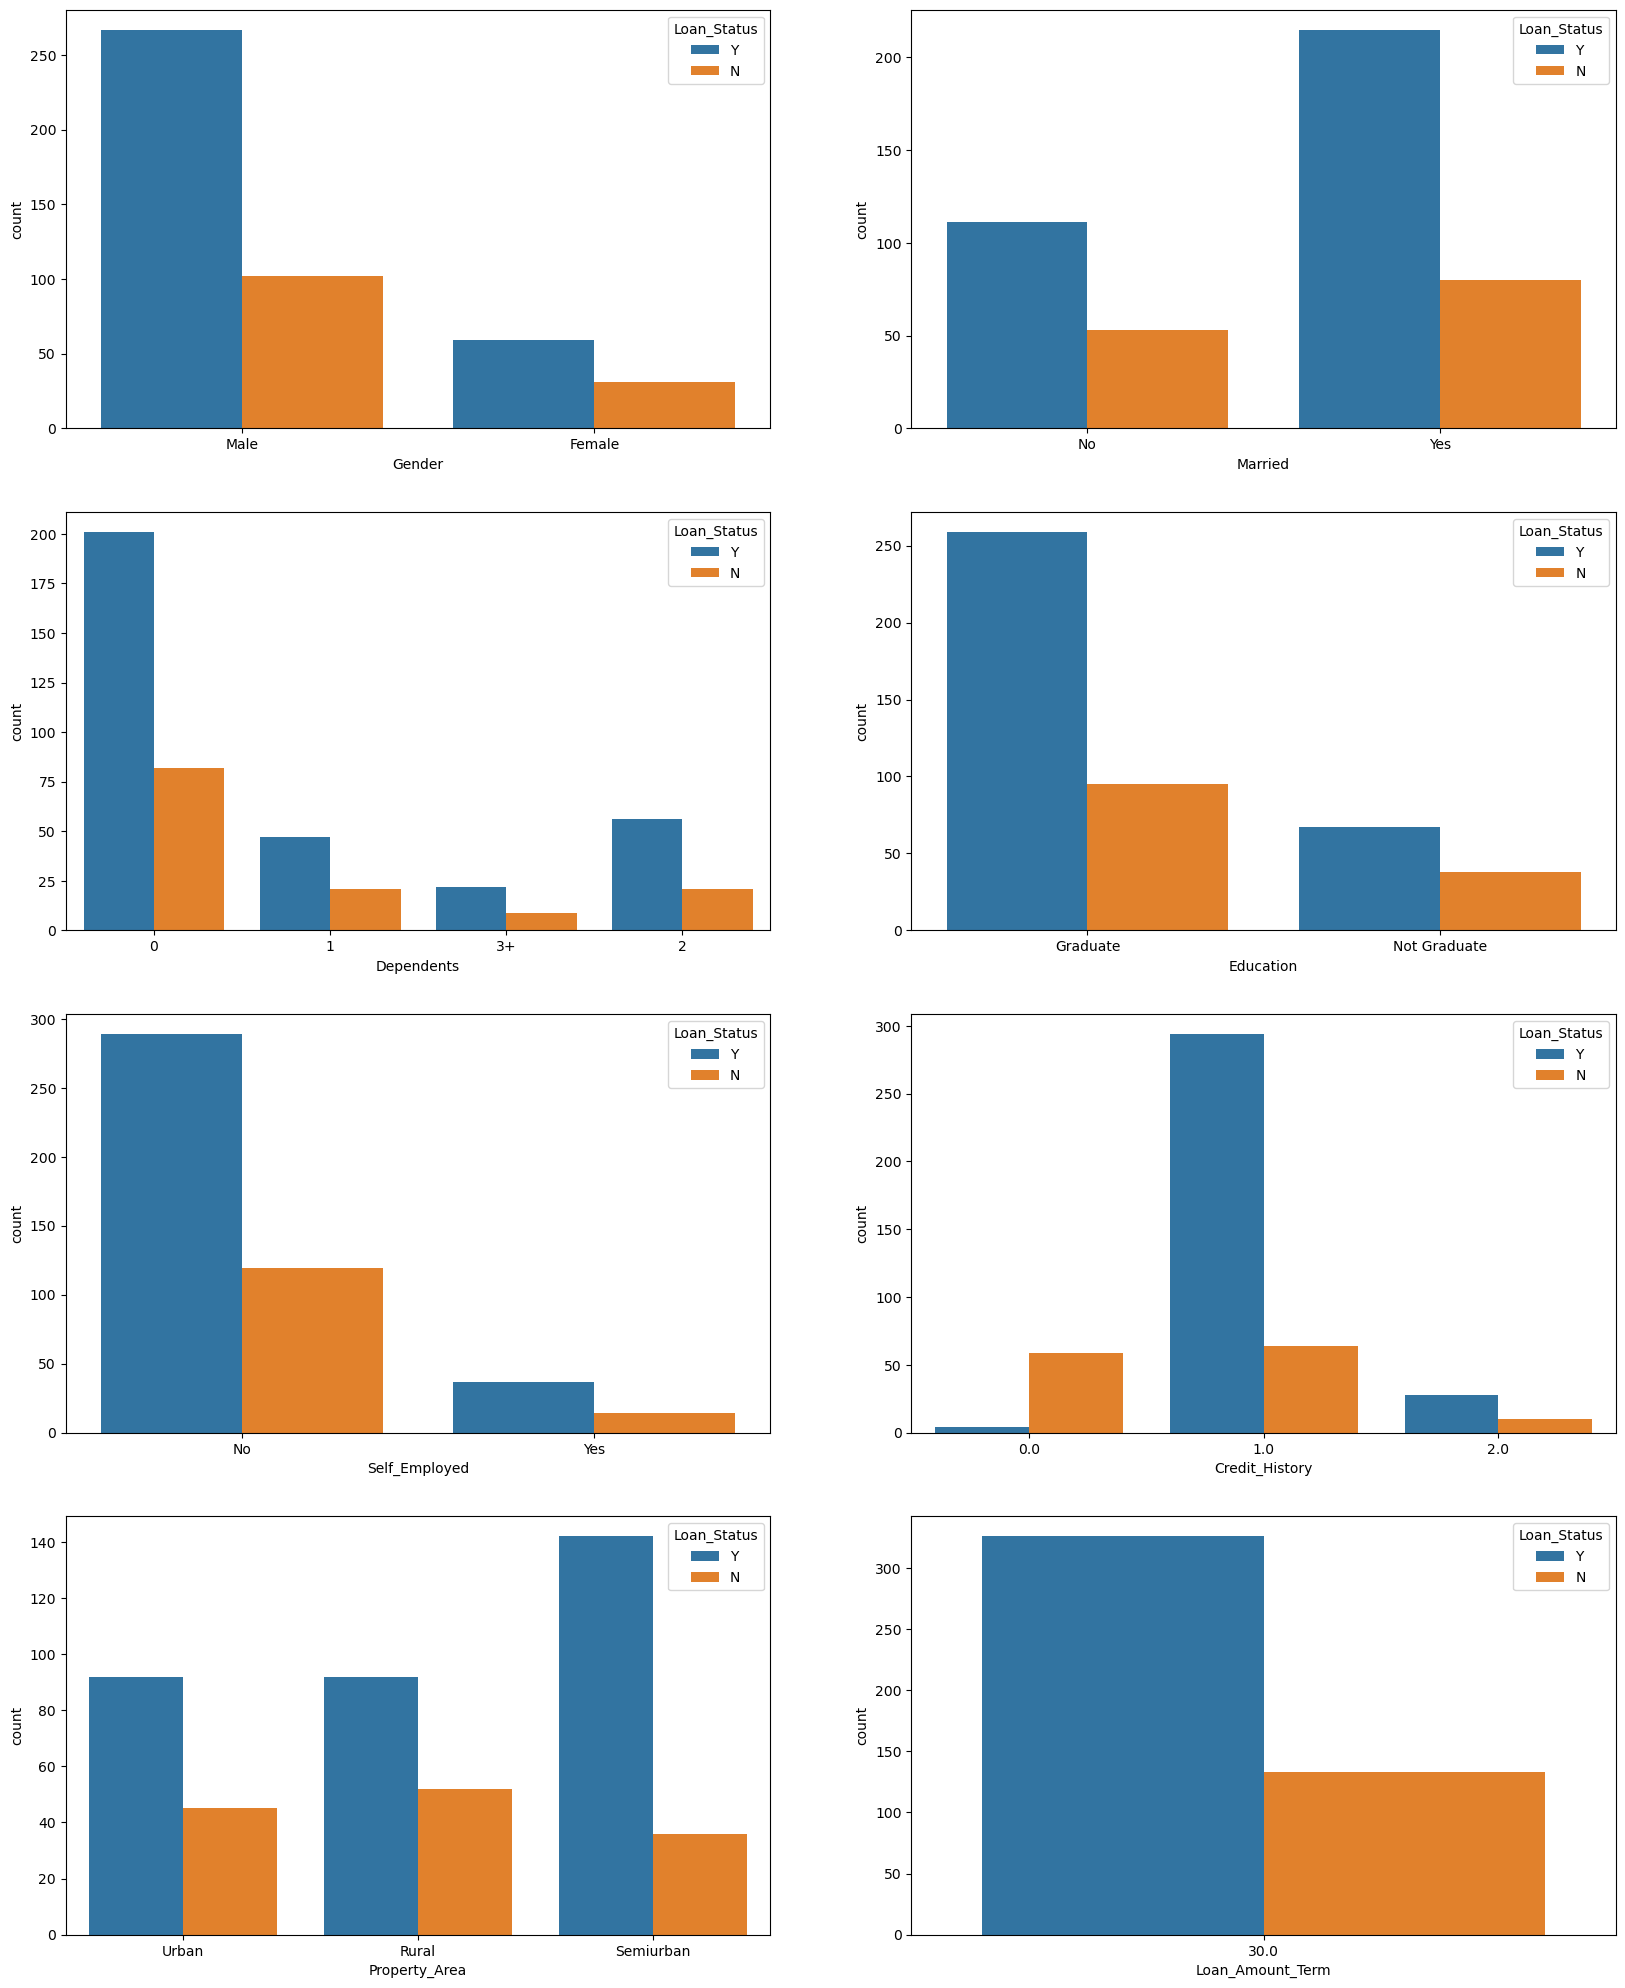

In [135]:
#Bi variate analysis-cat
x=0
plt.figure(figsize=(20,25))
for col in cat_col:
    x+=1
    plt.subplot(4,2,x)
    plt.ylabel("Count")
    plt.xlabel(col)
    sns.countplot(data=clean_data,x=col,hue='Loan_Status')

<AxesSubplot:xlabel='Credit_History', ylabel='LoanAmount'>

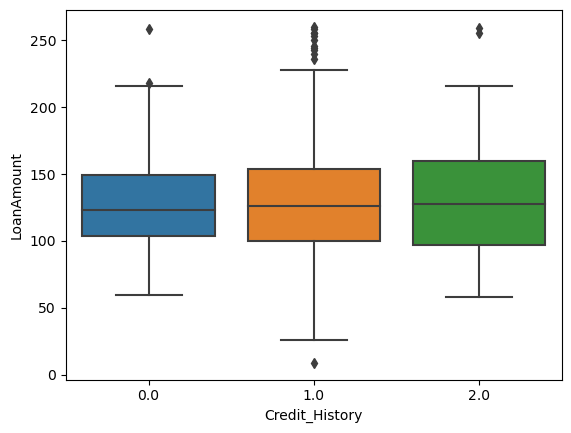

In [136]:
sns.boxplot(data=clean_data,x='Credit_History',y='LoanAmount')

<AxesSubplot:xlabel='Loan_Status', ylabel='LoanAmount'>

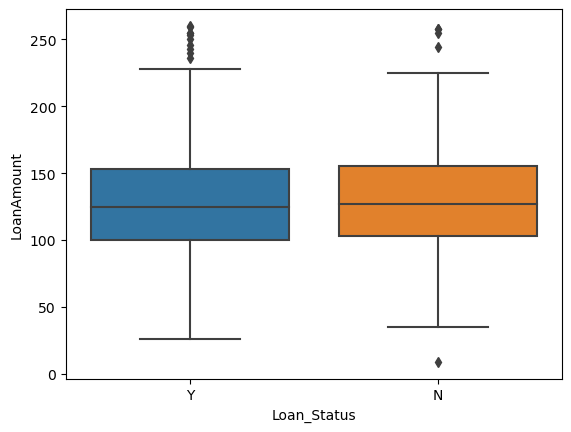

In [137]:
sns.boxplot(data=clean_data,x='Loan_Status',y='LoanAmount')

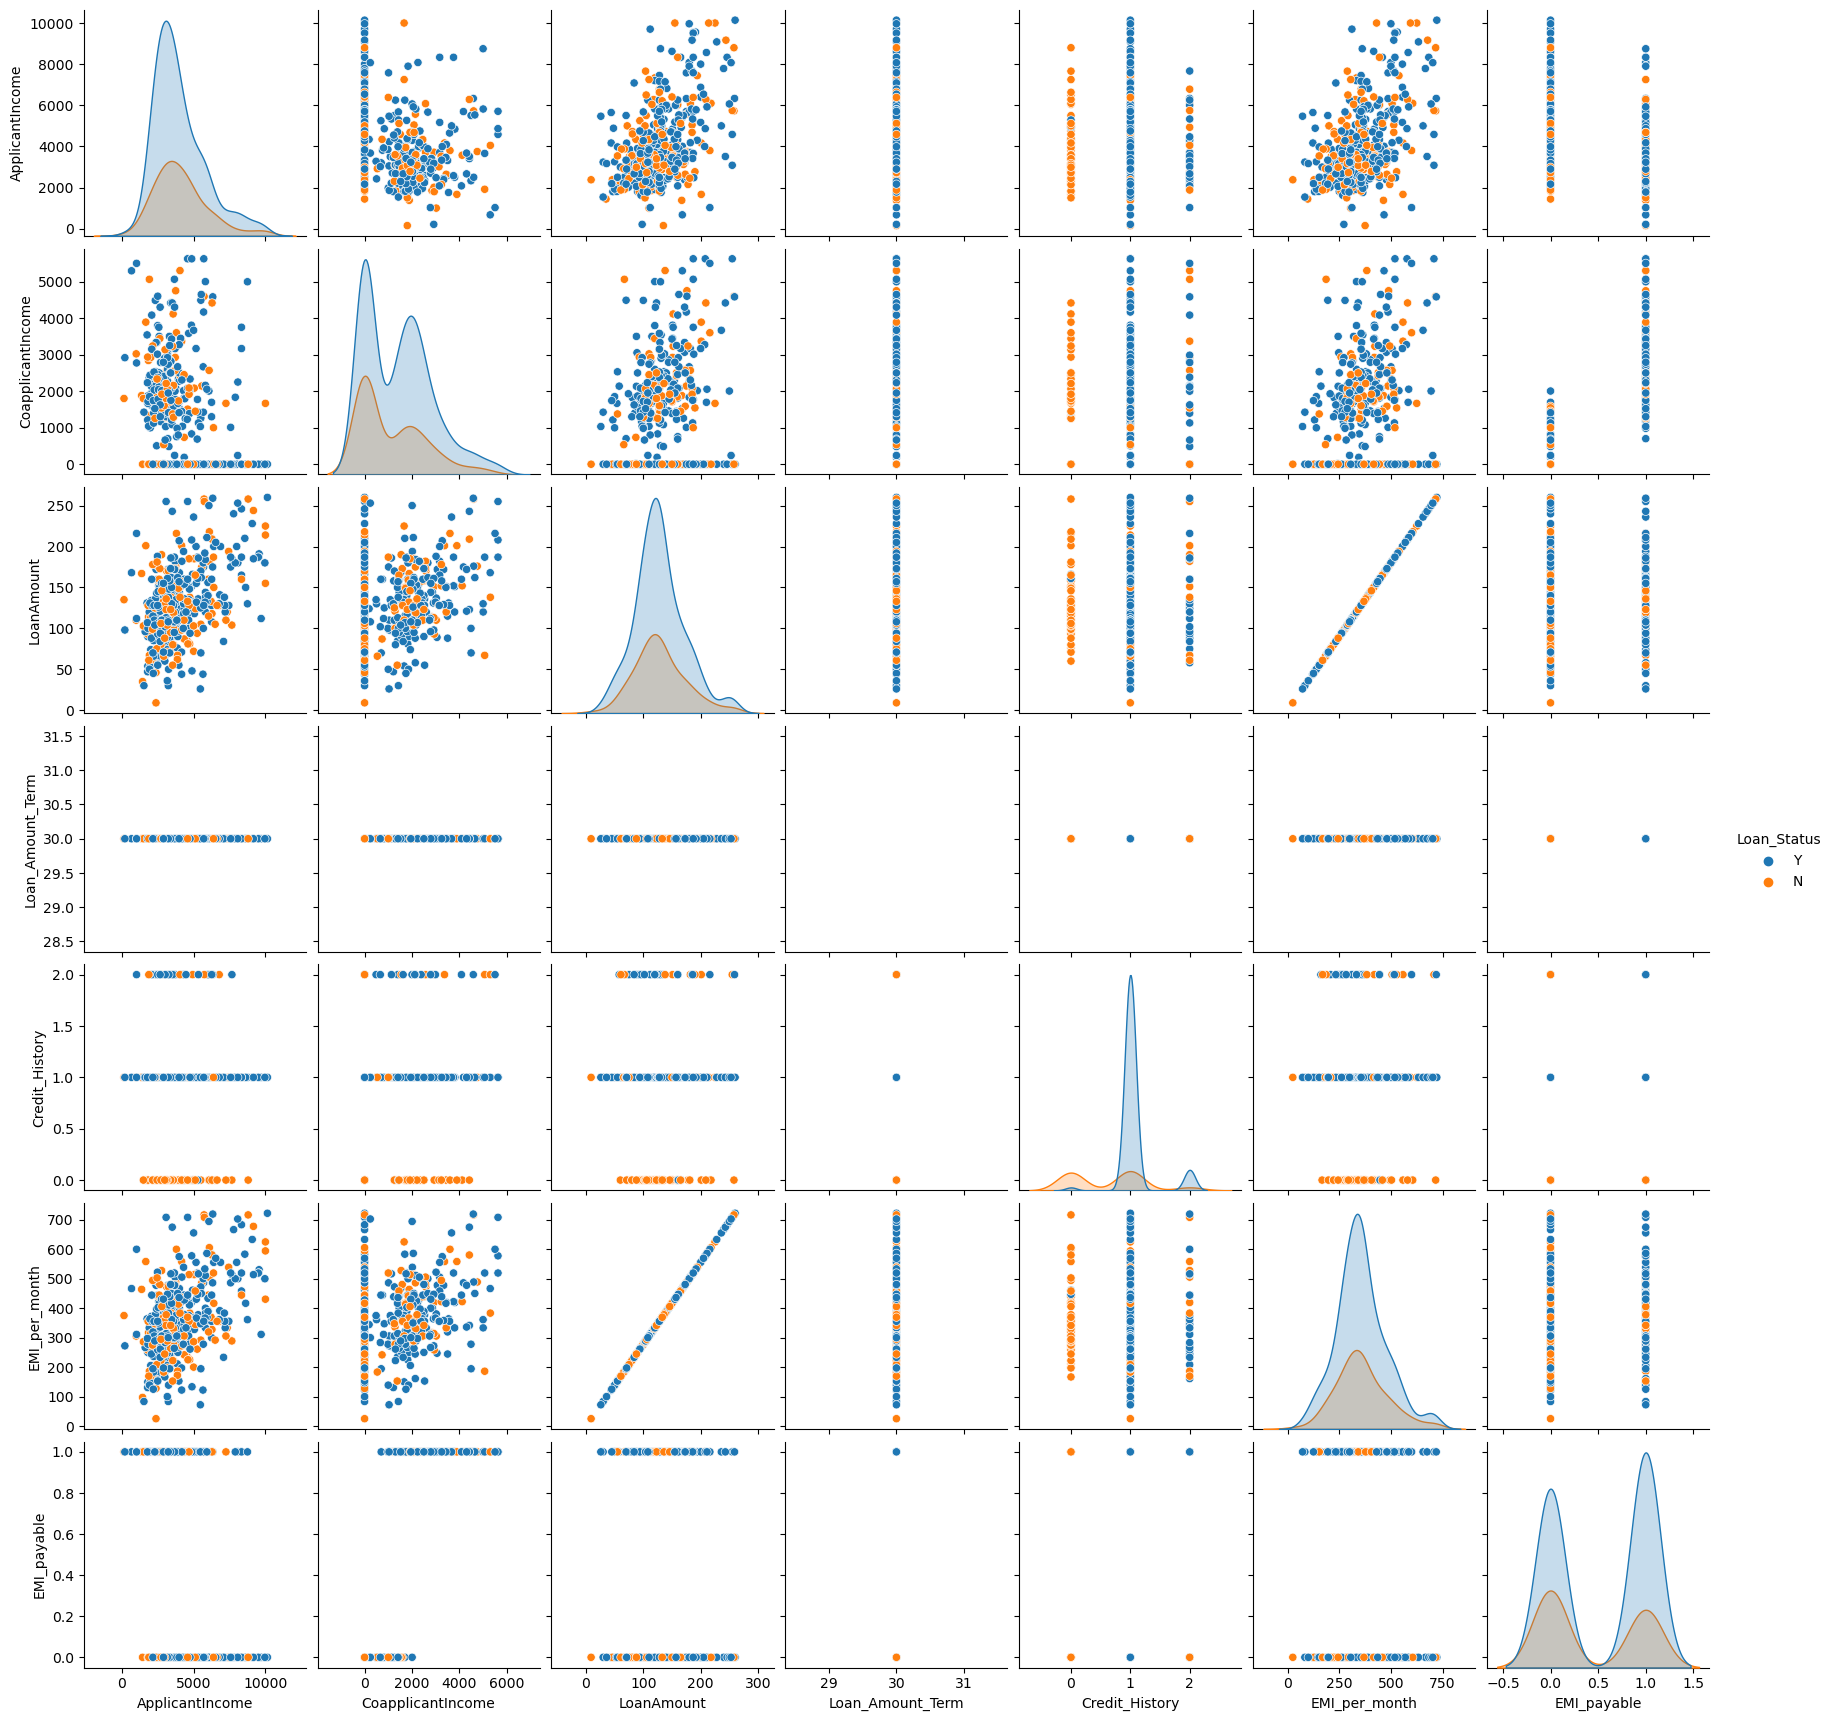

In [138]:
sns.pairplot(data=clean_data,hue='Loan_Status')

<AxesSubplot:>

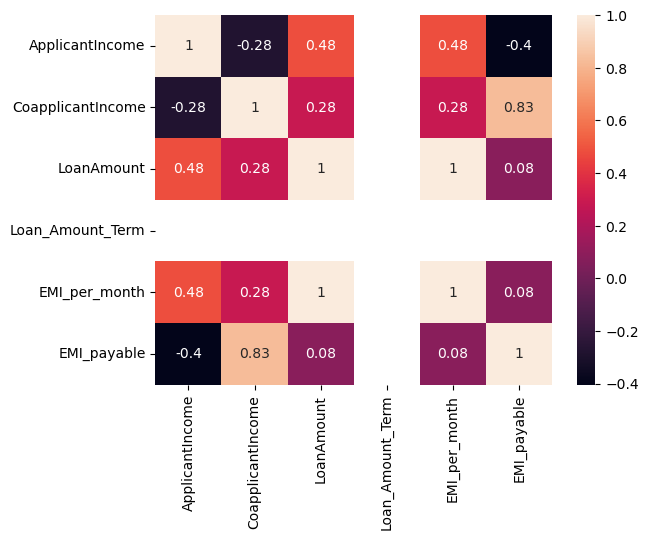

In [139]:
sns.heatmap(clean_data.corr(),annot=True)

In [140]:
#So from the analysis we have done the columns that impact th eloans status are mentioned below

In [141]:
print(f'attributes that impact loan approval{dependent_att}')

attributes that impact loan approval['Credit_History', 'Property_Area', 'CoapplicantIncome', 'EMI_payable']


## From the analysis I identified that 
#### 'Credit_History', 
#### 'Property_Area', 
#### 'CoapplicantIncome', 
#### 'EMI_payable' 
## are the main factors that impact the loan status


In [142]:
#Now lets prepare the data from ML .we will normalize the data and convert categro data to numerical


In [143]:
min_max = MinMaxScaler()
clean_data['CoapplicantIncome']=min_max.fit_transform(clean_data[['CoapplicantIncome']])


C:\Users\denms\AppData\Local\Temp\ipykernel_44964\1061972479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['CoapplicantIncome']=min_max.fit_transform(clean_data[['CoapplicantIncome']])


In [144]:
lab_en=LabelEncoder()
clean_data['Married']=lab_en.fit_transform(clean_data['Married'])

C:\Users\denms\AppData\Local\Temp\ipykernel_44964\4164503690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Married']=lab_en.fit_transform(clean_data['Married'])


In [145]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [146]:

clean_data['Loan_Status'].replace(['N','Y'],[0,1],inplace=True)
tar_en=TargetEncoder()
clean_data['Property_Area']=tar_en.fit_transform(clean_data['Property_Area'],clean_data['Loan_Status'])

C:\Users\denms\AppData\Local\Temp\ipykernel_44964\418446286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Loan_Status'].replace(['N','Y'],[0,1],inplace=True)
C:\Users\denms\AppData\Local\Temp\ipykernel_44964\418446286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Property_Area']=tar_en.fit_transform(clean_data['Property_Area'],clean_data['Loan_Status'])


In [147]:
procesed_data=clean_data[list(set(dependent_att))]
procesed_data

,Credit_History,Property_Area,EMI_payable,CoapplicantIncome
0,1.0,0.671533,0,0.000000
1,1.0,0.638889,1,0.268089
2,1.0,0.671533,0,0.000000
3,1.0,0.671533,1,0.419200
4,1.0,0.671533,0,0.000000
...,...,...,...,...
608,1.0,0.638889,1,0.346667
609,1.0,0.638889,0,0.000000
611,1.0,0.671533,0,0.042667
612,1.0,0.671533,0,0.000000
